In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

  Created wheel for mendelai-brat-parser: filename=mendelai_brat_parser-0.0.11-py3-none-any.whl size=4945 sha256=9104be4f095a48eee3b2cfa8aa78e133873ce33f5ec070f1aff5dbbc09a85ad1
  Stored in directory: /root/.cache/pip/wheels/7e/40/73/4f68f4fa597be33e250400cd56c28c85862b1cba5b3c7c33f1
Successfully built mendelai-brat-parser
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import regex as re
from collections import Counter
import math

from google.colab import files
import zipfile
import glob

import xml.etree.ElementTree as ET
from brat_parser import get_entities_relations_attributes_groups

from nltk.tag import pos_tag, map_tag

from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from brat_parser import get_entities_relations_attributes_groups

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Neural network imports.
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input, Dropout
from keras.layers import TimeDistributed
from keras.layers import Concatenate
from keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Input

# **Relations Dataframes**

In [ ]:
# Import the datataset, created in a previous moment, (essay_relation_dataset.csv) 
# containing an entry for each relation of the Stab and Gurevych dataset.
# Each entry is composed as: 
# (type,doc_id,supporting_text,supporting_type,supporting_sentence_id,supporting_section_length,supported_text,supported_type,supported_sentence_id,supported_section_length)
# where type is the relation tipe (attack, support, none).
# supporting and supported refer to the two section of the corpus that are in a relation:
# text refers to their original texts, type if they are a premise or a claim, the length to the number of sentences in the arg. section after the first one,  and sentence_id
# indicates the position in the corpus of the sentence that contains them.
print('\nImport essay_relation_dataset.csv\n')
uploaded = files.upload()


Import essay_relation_dataset.csv



Saving essay_relation_dataset.csv to essay_relation_dataset.csv


In [ ]:
# Import the datataset created in a previous moment (microtext_relation_dataset.csv) 
# containing an entry for each relation of the arg-microtext dataset.
# Each entry is composed as: 
# (doc_id,supporting_text,supporting_sentence_id,supporting_section_length,supported_text,supported_sentence_id,supported_section_length)
# where type is the relation tipe (attack, support, none).
# supporting and supported refer to the two section of the corpus that are in a relation:
# text refers to their original texts, the length to the number of sentences in the arg. section after the first one,  and sentence_id
# indicates the position in the corpus of the sentence that contains them.
print('\nImport microtext_relation_dataset.csv\n')
uploaded = files.upload()


Import microtext_relation_dataset.csv



Saving microtext_relation_dataset.csv to microtext_relation_dataset.csv


In [ ]:
# Import the original Stab and Gurevych dataset (2017 version).

uploaded = files.upload()

Saving ArgumentAnnotatedEssays-2.0.zip to ArgumentAnnotatedEssays-2.0.zip


In [ ]:
# Import the microtexts dataset.

uploaded = files.upload()

Saving arg-microtexts-master.zip to arg-microtexts-master.zip


In [ ]:
# The imported dataset is here directly used.

microtext_relation_ann_dataset=pd.read_csv('microtext_relation_dataset.csv')

In [ ]:
microtext_relation_ann_dataset.head()

,type,doc_id,supporting_text,supporting_sentence_id,supported_text,supported_sentence_id
0,attacks,0,"Yes, it's annoying and cumbersome to separate ...",0,We Berliners should take the chance and become...,3
1,supports,0,Three different bin bags stink away in the kit...,1,"Yes, it's annoying and cumbersome to separate ...",0
2,supports,1,One can hardly move in Friedrichshain or Neukö...,4,Higher fines are therefore the right measure a...,6
3,supports,1,And when bad luck does strike and you step int...,5,Higher fines are therefore the right measure a...,6
4,attacks,1,"Of course, first they'd actually need to be ca...",7,Higher fines are therefore the right measure a...,6


In [ ]:
number_documents=len(list(set(microtext_relation_ann_dataset['doc_id'].tolist())))

In [ ]:
# The imported dataset is here directly used.
# MajorClaim have been removed from the argumentations in the imported dataset (they don't have labeled relations).

relation_ann_dataset=pd.read_csv('essay_relation_dataset.csv')

relation_ann_dataset=relation_ann_dataset.drop(['supporting_type', 'supported_type'], axis=1)

In [ ]:
relation_ann_dataset.head()

,type,doc_id,supporting_text,supporting_sentence_id,supporting_section_length,supported_text,supported_sentence_id,supported_section_length
0,supports,0,What we acquired from team work is not only ho...,5,0,"through cooperation, children can learn about ...",4,0
1,supports,0,"During the process of cooperation, children ca...",6,0,"through cooperation, children can learn about ...",4,0
2,supports,0,All of these skills help them to get on well w...,7,0,"through cooperation, children can learn about ...",4,0
3,supports,0,the significance of competition is that how to...,8,0,competition makes the society more effective,9,0
4,supports,0,when we consider about the question that how t...,10,0,"without the cooperation, there would be no vic...",14,0


In [ ]:
# The Microtext dataset.

relation_microtext_dataset=pd.read_csv('microtext_relation_dataset.csv')

In [ ]:
relation_microtext_dataset.head()

,type,doc_id,supporting_text,supporting_sentence_id,supported_text,supported_sentence_id
0,attacks,0,"Yes, it's annoying and cumbersome to separate ...",0,We Berliners should take the chance and become...,3
1,supports,0,Three different bin bags stink away in the kit...,1,"Yes, it's annoying and cumbersome to separate ...",0
2,supports,1,One can hardly move in Friedrichshain or Neukö...,4,Higher fines are therefore the right measure a...,6
3,supports,1,And when bad luck does strike and you step int...,5,Higher fines are therefore the right measure a...,6
4,attacks,1,"Of course, first they'd actually need to be ca...",7,Higher fines are therefore the right measure a...,6


# **Stab Gurevych dataset**

In [ ]:
# Function to extract zip file.
# Takes in input the path to the zip file (path_zip) and the one to store the destination directory (path_destination).

def extract_zip(path_zip,path_destination):
  with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(path_destination)


In [ ]:
# Extract zip file (two zip files one inside the other).

extract_zip('ArgumentAnnotatedEssays-2.0.zip','ArgumentAnnotatedEssays-2.0')

extract_zip('ArgumentAnnotatedEssays-2.0/ArgumentAnnotatedEssays-2.0/brat-project-final.zip','ArgumentAnnotatedEssays')

## **Create and visualize the required Dataframe**

In [ ]:
# Extract the list of text files of the essays in the dataset.
txt_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.txt"))

# Extract the list of text files of the essays in the dataset.
ann_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.ann"))

In [ ]:
# List of text files of the essays.
txt_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.txt']

In [ ]:
# List of the annotated files of the essays.
ann_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.ann']

In [ ]:
# Transfor the ann files into four dictionaries.
ann_disctionaries=[get_entities_relations_attributes_groups(file) for file in ann_files]

# Transform the first dictionary (entities) obtained from each ann file into a dataset.
essay_ann_datasets = [pd.DataFrame.from_dict(entities, orient='index') for entities,_,_,_ in ann_disctionaries]

In [ ]:
# Sort the lists composed of a (entity) dataset for each essay.
essay_ann_datasets=[dataset.sort_values(by='span', key=lambda col: col.map(lambda x: x[0][0])) for dataset in essay_ann_datasets]  

# Add a coloumn into the dataset that identifies the document
for i in range(len(essay_ann_datasets)):
  essay_ann_datasets[i].insert(0,'doc_id',i)

# Create a common dataset
essay_argument_dataset = pd.concat(essay_ann_datasets)

In [ ]:
# Sobstitue the values in the "span" feature (substitute each tuple with its first inner tuple)
for i in range(len(essay_argument_dataset.index)):
  essay_argument_dataset['span'][i]=essay_argument_dataset['span'][i][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
essay_argument_dataset.head()

,doc_id,id,type,span,text
T1,0,T1,MajorClaim,"(503, 575)",we should attach more importance to cooperatio...
T3,0,T3,Claim,"(591, 714)","through cooperation, children can learn about ..."
T4,0,T4,Premise,"(716, 851)",What we acquired from team work is not only ho...
T5,0,T5,Premise,"(853, 1086)","During the process of cooperation, children ca..."
T6,0,T6,Premise,"(1088, 1191)",All of these skills help them to get on well w...


## **Word list of the Corpus**

In [ ]:
# List of texts of the essays
files_text=[open(file).read() for file in txt_files]

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "span" coloumn of the Dataframe of the annotation.

sorted_span=[list(essay_argument_dataset.loc[essay_argument_dataset['doc_id'] == i,['span','type']].values) for i in range(len(ann_files))]

In [ ]:
sorted_span[0]

[array([(503, 575), 'MajorClaim'], dtype=object),
 array([(591, 714), 'Claim'], dtype=object),
 array([(716, 851), 'Premise'], dtype=object),
 array([(853, 1086), 'Premise'], dtype=object),
 array([(1088, 1191), 'Premise'], dtype=object),
 array([(1212, 1301), 'Premise'], dtype=object),
 array([(1332, 1376), 'Claim'], dtype=object),
 array([(1387, 1492), 'Premise'], dtype=object),
 array([(1549, 1846), 'Premise'], dtype=object),
 array([(1927, 1992), 'Claim'], dtype=object),
 array([(2154, 2231), 'MajorClaim'], dtype=object)]

In [ ]:
# Tranform the couples of points ((start,end) of each section) to a list (separator of different section).

span_points=[]

for i in range(len(sorted_span)):
  list_points=[sep for sub in sorted_span[i] for sep in sub[0]]
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(files_text[i]))
  span_points.append(list_points)

In [ ]:
span_points[0]

[0,
 503,
 575,
 591,
 714,
 716,
 851,
 853,
 1086,
 1088,
 1191,
 1212,
 1301,
 1332,
 1376,
 1387,
 1492,
 1549,
 1846,
 1927,
 1992,
 2154,
 2231,
 2232]

In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(files_text)):
  split_text.append([files_text[z][i: j] for i, j in zip(span_points[z], span_points[z][1:])])

In [ ]:
split_text[0][0:10]

["Should students be taught to compete or to cooperate?\n\nIt is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that ",
 'we should attach more importance to cooperation during primary education',
 '.\nFirst of all, ',
 'through cooperation, children can learn about interpersonal skills which are significant in the future life of all students',
 '. ',
 'What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others',
 '. ',
 'During the process of cooperation, children can learn about how to listen to opinions of others, how to com

In [ ]:
# Get the list of the words of each essay.

X_essay_word_list=[]

for i in range(len(split_text)):
  
  essay_word_list=[]

  # Remove title from essay considered (splitted_text)
  no_title=[re.sub(r".*\n\n","",text) for text in split_text[i]]

  for section in no_title:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    essay_word_list+=seq

  X_essay_word_list.append(essay_word_list)

In [ ]:
X_essay_word_list[0][80:120]

['i',
 'firmly',
 'believe',
 'that',
 'we',
 'should',
 'attach',
 'more',
 'importance',
 'to',
 'cooperation',
 'during',
 'primary',
 'education',
 '.',
 'first',
 'of',
 'all',
 ',',
 'through',
 'cooperation',
 ',',
 'children',
 'can',
 'learn',
 'about',
 'interpersonal',
 'skills',
 'which',
 'are',
 'significant',
 'in',
 'the',
 'future',
 'life',
 'of',
 'all',
 'students',
 '.',
 'what']

## **Find out sentences list**

In [ ]:
# Get the list of all the sentences.

sentence_list=[]

# Get the list of the id of the essay for each of the sentences of the corpus.
essay_id_list=[]


for essay_id in range(len(X_essay_word_list)):
  sentence=""

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not ( word=="." ):
      sentence+=word+" "
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and ( not sentence==""):
      sentence_list.append(sentence)
      essay_id_list.append(essay_id)

      sentence=""

  if not (sentence==""):
      sentence_list.append(sentence)
      essay_id_list.append(essay_id)

In [ ]:
len(sentence_list)

6738

## **Select the sections to classify and the labels**

In [ ]:
# Get the list of the words of each argumentative section that is part of a 
# relation.

# List of the argumentative sections in the relations imported.
X_supporting_section_list=[]
X_supported_section_list=[]

# List of the sentences before each argumentative sections in the relations imported.
X_supporting_section_list_before=[]
X_supported_section_list_before=[]

# List of the sentences after each argumentative sections in the relations imported.
X_supporting_section_list_after=[]
X_supported_section_list_after=[]

for relation in relation_ann_dataset.itertuples():

  supporting=""
  supported=""

  supporting_sequence=relation.supporting_text
  supported_sequence=relation.supported_text

  supporting_sentence_id=relation.supporting_sentence_id
  supported_sentence_id=relation.supported_sentence_id

  supporting_section_length=relation.supporting_section_length
  supported_section_length=relation.supported_section_length

  # Divide the sections into token.
  supporting_seq_word=nltk.word_tokenize(supporting_sequence.lower())
  supported_seq_word=nltk.word_tokenize(supported_sequence.lower())

  for word in supporting_seq_word:
    supporting+=word+" "

  for word in supported_seq_word:
    supported+=word+" "

  # Concatenate the sentences before and atfer the ones that contain the argumentation
  # separately.
  # If the sentences don't end with a "?" or a "!", add a period (".") at the end;
  # the sentences are stored without the periods.
  supporting_sentence=sentence_list[supporting_sentence_id]

  for j in range(supporting_section_length):
    if not (supporting_sentence[-2]=='?' or supporting_sentence[-2]=='!'):
      supporting_sentence+=". "+sentence_list[supporting_sentence_id+j+1]
    else:
      supporting_sentence+=sentence_list[supporting_sentence_id+j+1]

  supported_sentence=sentence_list[supported_sentence_id]

  for j in range(supported_section_length):
    if not (supported_sentence[-2]=='?' or supported_sentence[-2]=='!'):
      supported_sentence+=". "+sentence_list[supported_sentence_id+j+1]
    else:
      supported_sentence+=sentence_list[supported_sentence_id+j+1]    

  # Get the parts of the sentence containing the argumentative section before
  # and after the section.
  supporting_before,supporting_after=supporting_sentence.split(supporting)
  supported_before,supported_after=supported_sentence.split(supported)

  # If the section it isn't in the first sentence of an essay attach to the
  # already retrieved preciding section the entire sentence before the one 
  # containing the section. 

  if (supporting_sentence_id>0) and (essay_id_list[supporting_sentence_id]==essay_id_list[supporting_sentence_id-1]):
    sentence_before=sentence_list[supporting_sentence_id-1]
    if not (sentence_before[-2]=='?' or sentence_before[-2]=='!'):
      supporting_before=sentence_before+". "+supporting_before
    else:
      supporting_before=sentence_before+" "+supporting_before


  if (supported_sentence_id>0) and (essay_id_list[supported_sentence_id]==essay_id_list[supported_sentence_id-1]):
    sentence_before=sentence_list[supported_sentence_id-1]
    if not (sentence_before[-2]=='?' or sentence_before[-2]=='!'):
      supported_before=sentence_before+". "+supported_before
    else:
      supported_before=sentence_before+" "+supported_before 

  # If the section it isn't in the last sentence of an essay attach to the
  # already retrieved following section the entire sentence after the one 
  # containing the section. 

  if (supporting_sentence_id<len(sentence_list)-1) and (essay_id_list[supporting_sentence_id]==essay_id_list[supporting_sentence_id+1]):
    sentence_after=sentence_list[supporting_sentence_id+supporting_section_length+1]
    if len(supporting_after)>1 and (supporting_after[-2]=='?' or supporting_after[-2]=='!'):
      supporting_after=supporting_after+" "+sentence_after
    else:
      supporting_after=supporting_after+". "+sentence_after

  if (supported_sentence_id<len(sentence_list)-1) and (essay_id_list[supported_sentence_id]==essay_id_list[supported_sentence_id+1]):
    sentence_after=sentence_list[supported_sentence_id+supported_section_length+1]
    if len(supported_after)>1 and (supported_after[-2]=='?' or supported_after[-2]=='!'):
      supported_after=supported_after+" "+sentence_after
    else:
      supported_after=supported_after+". "+sentence_after  

  X_supporting_section_list.append(supporting)
  X_supported_section_list.append(supported)
  X_supporting_section_list_before.append(supporting_before)
  X_supported_section_list_before.append(supported_before)
  X_supporting_section_list_after.append(supporting_after)
  X_supported_section_list_after.append(supported_after)

In [ ]:
X_supporting_section_list[:5]

['what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 'during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred ',
 'all of these skills help them to get on well with other people and will benefit them for the whole life ',
 'the significance of competition is that how to become more excellence to gain the victory ',
 'when we consider about the question that how to win the game , we always find that we need the cooperation ']

In [ ]:
X_supporting_section_list_before[:5]

['first of all , through cooperation , children can learn about interpersonal skills which are significant in the future life of all students . ',
 'what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others . ',
 'during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred . ',
 'all of these skills help them to get on well with other people and will benefit them for the whole life . on the other hand , ',
 'hence it is always said that competition makes the society more effective . however , ']

In [ ]:
X_supporting_section_list_after[:5]

['. during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred ',
 '. all of these skills help them to get on well with other people and will benefit them for the whole life ',
 '. on the other hand , the significance of competition is that how to become more excellence to gain the victory ',
 '. hence it is always said that competition makes the society more effective ',
 '. the greater our goal is , the more competition we need ']

In [ ]:
X_supported_section_list[:5]

['through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'competition makes the society more effective ',
 'without the cooperation , there would be no victory of competition ']

In [ ]:
X_supported_section_list_before[:5]

['from this point of view , i firmly believe that we should attach more importance to cooperation during primary education . first of all , ',
 'from this point of view , i firmly believe that we should attach more importance to cooperation during primary education . first of all , ',
 'from this point of view , i firmly believe that we should attach more importance to cooperation during primary education . first of all , ',
 'on the other hand , the significance of competition is that how to become more excellence to gain the victory . hence it is always said that ',
 'the winner is the athlete but the success belongs to the whole team . therefore ']

In [ ]:
X_supported_section_list_after[:5]

['. what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 '. what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 '. what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 '. however , when we consider about the question that how to win the game , we always find that we need the cooperation ',
 ". consequently , no matter from the view of individual development or the relationship between competition and cooperation we can receive the same conclusion that a more cooperative attitudes towards life is more profitable in one 's success "]

In [ ]:
X_supported_word_list_after=[nltk.word_tokenize(section) for section in X_supported_section_list_after]
X_supporting_word_list_after=[nltk.word_tokenize(section) for section in X_supporting_section_list_after]
X_supported_word_list_before=[nltk.word_tokenize(section) for section in X_supported_section_list_before]
X_supporting_word_list_before=[nltk.word_tokenize(section) for section in X_supporting_section_list_before]
X_supported_word_list=[nltk.word_tokenize(section) for section in X_supported_section_list]
X_supporting_word_list=[nltk.word_tokenize(section) for section in X_supporting_section_list]

In [ ]:
Y_relation_type=relation_ann_dataset["type"].tolist()

Y_relation_type[:10]

['supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'None']

In [ ]:
Y_relation_type_temp=[]

for rel in Y_relation_type:
  if rel=="supports":
    Y_relation_type_temp.append(1)
  else:
    if rel=="None":
      Y_relation_type_temp.append(0)
    else:
      Y_relation_type_temp.append(2)

Y_relation_type=Y_relation_type_temp

Y_relation_type[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [ ]:
# Definition of the class weights to reduce the impact of the imbalance in the dataset.
class_weights={0: 1, 1: 1, 2:8}

# **Microtext Dataset**

In [ ]:
# Function to extract zip file.
# Takes in input the path to the zip file (path_zip) and the one to store the destination directory (path_destination).

def extract_zip(path_zip,path_destination):
  with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(path_destination)

In [ ]:
# Extract zip file.

extract_zip('arg-microtexts-master.zip','arg-microtexts-master')

## **Extract argumentative sections and their relations**

In [ ]:
# Extract the list of xml files containing the argumentative sections in the 
# dataset and their relations.

xml_files = sorted(glob.glob("arg-microtexts-master/arg-microtexts-master/corpus/en/micro_*.xml"))

In [ ]:
# List of xml files of the essays.
xml_files[0:5]

['arg-microtexts-master/arg-microtexts-master/corpus/en/micro_b001.xml',
 'arg-microtexts-master/arg-microtexts-master/corpus/en/micro_b002.xml',
 'arg-microtexts-master/arg-microtexts-master/corpus/en/micro_b003.xml',
 'arg-microtexts-master/arg-microtexts-master/corpus/en/micro_b004.xml',
 'arg-microtexts-master/arg-microtexts-master/corpus/en/micro_b005.xml']

In [ ]:
# Transform each xml file into the xml tree representation.

list_xml_tree_representation=[ET.parse(xml_file) for xml_file in xml_files]

# Than extract from each tree its root.

list_xml_root=[tree.getroot() for tree in list_xml_tree_representation]

In [ ]:
# list_argumentative_sections will contain the lists, for each document in the
# corpus, of its argumentative sections.
list_argumentative_sections=[]
# list_arg_section_id_in_document will contain the lists, for each document in
# the corpus, of the id that identify the sections inside the document.
list_arg_section_id_in_document=[]


for root_id in range(len(list_xml_root)):
  temp_list_argumentative_sections=[]
  temp_list_arg_section_id_in_document=[]
  new_temp_list_arg_section_id_in_document=[]
  for child in list_xml_root[root_id]:
    # The nodes tagged with 'edu' contains the text of the arg. section and an unique identifier in the document.
    if child.tag=='edu':
      temp_list_argumentative_sections.append(child.text)
      temp_list_arg_section_id_in_document.append(child.get('id'))
    # In the 'edge' nodes the original id of the sections (in src) are sobstitute with new ones (in trg).
    if (child.tag=='edge'):
      src=child.get('src')
      trg=child.get('trg')
      if src in temp_list_arg_section_id_in_document:
        new_temp_list_arg_section_id_in_document.append(trg)

  list_argumentative_sections.append(temp_list_argumentative_sections)
  list_arg_section_id_in_document.append(new_temp_list_arg_section_id_in_document)

In [ ]:
for i in range(len(list_argumentative_sections[0])):
  print("section {} in document {}: {}".format(list_arg_section_id_in_document[0][i],0,list_argumentative_sections[0][i]))

section a1 in document 0: Yes, it's annoying and cumbersome to separate your rubbish properly all the time.
section a2 in document 0: Three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins.
section a3 in document 0: But still Germany produces way too much rubbish
section a4 in document 0: and too many resources are lost when what actually should be separated and recycled is burnt.
section a5 in document 0: We Berliners should take the chance and become pioneers in waste separation!


## **Extract sentences**

In [ ]:
# All the argumentative sections are contained in a single sentence.

# Get the list of all the sentences.
microtext_sentence_list=[]

# Get the list of the document containing each sentence(one element per sentence).
microtext_sentence_document=[]

for i in range(len(list_argumentative_sections)):
  sentence=""
  for j in range(len(list_argumentative_sections[i])):

    sentence+=list_argumentative_sections[i][j]

    # An argumentative section which ends a sentence has a '.' as last character.
    if sentence[-1] in ['.','!','?']:
      microtext_sentence_list.append(sentence)
      # Add an id of the document in which the sentence appear in the correspondent list.
      microtext_sentence_document.append(i)
      sentence=""

  if not (sentence==""):  
    microtext_sentence_list.append(sentence)
    # Add an id of the document in which the sentence appear in the correspondent list.
    microtext_sentence_document.append(i)
    sentence="" 

In [ ]:
microtext_sentence_list[:10]

["Yes, it's annoying and cumbersome to separate your rubbish properly all the time.",
 'Three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins.',
 'But still Germany produces way too much rubbishand too many resources are lost when what actually should be separated and recycled is burnt.',
 'We Berliners should take the chance and become pioneers in waste separation!',
 'One can hardly move in Friedrichshain or Neukölln these days without permanently scanning the ground for dog dirt.',
 "And when bad luck does strike and you step into one of the many 'land mines' you have to painstakingly scrape the remains off your soles.",
 'Higher fines are therefore the right measure against negligent, lazy or simply thoughtless dog owners.',
 "Of course, first they'd actually need to be caught in the act by public order officers,but once they have to dig into their pockets, their laziness will sure vanish!",
 'Health insurance companies should not cove

In [ ]:
len(microtext_sentence_list)

450

## **Select the sections to classify and the labels**

In [ ]:
# Get the list of the words of each argumentative section that is part of a 
# relation.

# List of the argumentative sections in the relations imported.
X_microtext_supporting_section_list=[]
X_microtext_supported_section_list=[]

# List of the sentences before each argumentative sections in the relations imported.
X_microtext_supporting_section_list_before=[]
X_microtext_supported_section_list_before=[]

# List of the sentences after each argumentative sections in the relations imported.
X_microtext_supporting_section_list_after=[]
X_microtext_supported_section_list_after=[]

for relation in relation_microtext_dataset.itertuples():

  supporting_sequence=relation.supporting_text
  supported_sequence=relation.supported_text

  supporting_sentence_id=relation.supporting_sentence_id
  supported_sentence_id=relation.supported_sentence_id

  # Concatenate the sentences before and atfer the ones that contain the argumentation
  # separately.
  supporting_sentence=microtext_sentence_list[supporting_sentence_id]

  supported_sentence=microtext_sentence_list[supported_sentence_id] 

  # Get the parts of the sentence containing the argumentative section before
  # and after the section.
  supporting_before,supporting_after=supporting_sentence.split(supporting_sequence)
  supported_before,supported_after=supported_sentence.split(supported_sequence)

  # If the section it isn't in the first sentence of an essay attach to the
  # already retrieved preciding section the entire sentence before the one 
  # containing the section.
  if (supporting_sentence_id>0) and (microtext_sentence_document[supporting_sentence_id]==microtext_sentence_document[supporting_sentence_id-1]):
    supporting_before=microtext_sentence_list[supporting_sentence_id-1]+" "+supporting_before

  if (supported_sentence_id>0) and (microtext_sentence_document[supporting_sentence_id]==microtext_sentence_document[supporting_sentence_id-1]):
    supported_before=microtext_sentence_list[supported_sentence_id-1]+" "+supported_before

  # If the section it isn't in the last sentence of an essay attach to the
  # already retrieved following section the entire sentence after the one 
  # containing the section. 

  if (supporting_sentence_id<len(microtext_sentence_list)-1) and (microtext_sentence_document[supporting_sentence_id]==microtext_sentence_document[supporting_sentence_id+1]):
      supporting_after=supporting_after+" "+microtext_sentence_list[supporting_sentence_id+1]

  if (supported_sentence_id<len(microtext_sentence_list)-1) and (microtext_sentence_document[supported_sentence_id]==microtext_sentence_document[supported_sentence_id+1]):
      supported_after=supported_after+" "+microtext_sentence_list[supported_sentence_id+1]


  # Divide the sections into token.
  supporting_seq_word=nltk.word_tokenize(supporting_sequence.lower())
  supported_seq_word=nltk.word_tokenize(supported_sequence.lower())

  supporting=""
  supported=""

  for word in supporting_seq_word:
    supporting+=word+" "

  for word in supported_seq_word:
    supported+=word+" "  

  X_microtext_supporting_section_list.append(supporting)
  X_microtext_supported_section_list.append(supported)

  supporting_seq_word=nltk.word_tokenize(supporting_before.lower())
  supported_seq_word=nltk.word_tokenize(supported_before.lower())

  supporting_before=""
  supported_before=""

  for word in supporting_seq_word:
    supporting_before+=word+" "

  for word in supported_seq_word:
    supported_before+=word+" " 

  X_microtext_supporting_section_list_before.append(supporting_before)
  X_microtext_supported_section_list_before.append(supported_before)

  supporting_seq_word=nltk.word_tokenize(supporting_after.lower())
  supported_seq_word=nltk.word_tokenize(supported_after.lower())

  supporting_after=""
  supported_after=""

  for word in supporting_seq_word:
    supporting_after+=word+" "

  for word in supported_seq_word:
    supported_after+=word+" " 

  X_microtext_supporting_section_list_after.append(supporting_after)
  X_microtext_supported_section_list_after.append(supported_after)

In [ ]:
X_microtext_supporting_section_list[:5]

["yes , it 's annoying and cumbersome to separate your rubbish properly all the time . ",
 'three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins . ',
 'one can hardly move in friedrichshain or neukölln these days without permanently scanning the ground for dog dirt . ',
 "and when bad luck does strike and you step into one of the many 'land mines ' you have to painstakingly scrape the remains off your soles . ",
 "of course , first they 'd actually need to be caught in the act by public order officers , "]

In [ ]:
X_microtext_supporting_section_list_before[:5]

['',
 "yes , it 's annoying and cumbersome to separate your rubbish properly all the time . ",
 '',
 'one can hardly move in friedrichshain or neukölln these days without permanently scanning the ground for dog dirt . ',
 'higher fines are therefore the right measure against negligent , lazy or simply thoughtless dog owners . ']

In [ ]:
X_microtext_supporting_section_list_after[:5]

['three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins . ',
 'but still germany produces way too much rubbishand too many resources are lost when what actually should be separated and recycled is burnt . ',
 "and when bad luck does strike and you step into one of the many 'land mines ' you have to painstakingly scrape the remains off your soles . ",
 'higher fines are therefore the right measure against negligent , lazy or simply thoughtless dog owners . ',
 'but once they have to dig into their pockets , their laziness will sure vanish ! ']

In [ ]:
X_microtext_supported_section_list[:5]

['we berliners should take the chance and become pioneers in waste separation ! ',
 "yes , it 's annoying and cumbersome to separate your rubbish properly all the time . ",
 'higher fines are therefore the right measure against negligent , lazy or simply thoughtless dog owners . ',
 'higher fines are therefore the right measure against negligent , lazy or simply thoughtless dog owners . ',
 'higher fines are therefore the right measure against negligent , lazy or simply thoughtless dog owners . ']

In [ ]:
X_microtext_supported_section_list_before[:5]

['',
 '',
 '',
 "and when bad luck does strike and you step into one of the many 'land mines ' you have to painstakingly scrape the remains off your soles . ",
 "and when bad luck does strike and you step into one of the many 'land mines ' you have to painstakingly scrape the remains off your soles . "]

In [ ]:
X_microtext_supported_section_list_after[:5]

['',
 'three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins . ',
 "of course , first they 'd actually need to be caught in the act by public order officers , but once they have to dig into their pockets , their laziness will sure vanish ! ",
 "of course , first they 'd actually need to be caught in the act by public order officers , but once they have to dig into their pockets , their laziness will sure vanish ! ",
 "of course , first they 'd actually need to be caught in the act by public order officers , but once they have to dig into their pockets , their laziness will sure vanish ! "]

In [ ]:
X_microtext_supported_word_list_after=[nltk.word_tokenize(section) for section in X_microtext_supported_section_list_after]
X_microtext_supporting_word_list_after=[nltk.word_tokenize(section) for section in X_microtext_supporting_section_list_after]
X_microtext_supported_word_list_before=[nltk.word_tokenize(section) for section in X_microtext_supported_section_list_before]
X_microtext_supporting_word_list_before=[nltk.word_tokenize(section) for section in X_microtext_supporting_section_list_before]
X_microtext_supported_word_list=[nltk.word_tokenize(section) for section in X_microtext_supported_section_list]
X_microtext_supporting_word_list=[nltk.word_tokenize(section) for section in X_microtext_supporting_section_list]

In [ ]:
Y_microtext_relation_type=relation_microtext_dataset["type"].tolist()

Y_microtext_relation_type[:10]

['attacks',
 'supports',
 'supports',
 'supports',
 'attacks',
 'attacks',
 'attacks',
 'attacks',
 'attacks',
 'attacks']

In [ ]:
Y_microtext_relation_type_temp=[]

for rel in Y_microtext_relation_type:
  if rel=="supports":
    Y_microtext_relation_type_temp.append(1)
  else:
    if rel=="None":
      Y_microtext_relation_type_temp.append(0)
    else:
      Y_microtext_relation_type_temp.append(2)

Y_microtext_relation_type=Y_microtext_relation_type_temp

Y_microtext_relation_type[:10]

[2, 1, 1, 1, 2, 2, 2, 2, 2, 2]

In [ ]:
Y_relation_type=Y_relation_type+Y_microtext_relation_type

# **Word2vec and one-hot-encoding**

In [ ]:
import gensim
import gensim.downloader as api

path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
# Load Google Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)  

In [ ]:
# Get the maximum lenght of the argumentative sections of the essays.

text_len = [len(text) for text in X_supporting_word_list+X_microtext_supporting_word_list]
MAX_LEN_SUPPORTING = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTING))

text_len = [len(text) for text in X_supported_word_list+X_microtext_supported_word_list]
MAX_LEN_SUPPORTED = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTED))

text_len = [len(text) for text in X_supporting_word_list+X_microtext_supporting_word_list]
MAX_LEN_SUPPORTING_BEFORE = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTING_BEFORE))

text_len = [len(text) for text in X_supported_word_list+X_microtext_supported_word_list]
MAX_LEN_SUPPORTED_BEFORE = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTED_BEFORE))

text_len = [len(text) for text in X_supporting_word_list+X_microtext_supporting_word_list]
MAX_LEN_SUPPORTING_AFTER = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTING_AFTER))

text_len = [len(text) for text in X_supported_word_list+X_microtext_supported_word_list]
MAX_LEN_SUPPORTED_AFTER = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTED_AFTER))

Max lenght of the supporting argumentative sections: 72
Max lenght of the supporting argumentative sections: 50
Max lenght of the supporting argumentative sections: 72
Max lenght of the supporting argumentative sections: 50
Max lenght of the supporting argumentative sections: 72
Max lenght of the supporting argumentative sections: 50


In [ ]:
text_tokenizer_supporting = Tokenizer()
text_tokenizer_supporting.fit_on_texts(X_supporting_word_list+X_microtext_supporting_word_list)
X_supporting = text_tokenizer_supporting.texts_to_sequences(X_supporting_word_list+X_microtext_supporting_word_list)
X_supporting = pad_sequences(X_supporting, maxlen=MAX_LEN_SUPPORTING, padding="pre")

text_tokenizer_supported = Tokenizer()
text_tokenizer_supported.fit_on_texts(X_supported_word_list+X_microtext_supported_word_list)
X_supported = text_tokenizer_supported.texts_to_sequences(X_supported_word_list+X_microtext_supported_word_list)
X_supported = pad_sequences(X_supported, maxlen=MAX_LEN_SUPPORTED, padding="pre")

text_tokenizer_supporting_before = Tokenizer()
text_tokenizer_supporting_before.fit_on_texts(X_supporting_word_list_before+X_microtext_supporting_word_list_before)
X_supporting_before = text_tokenizer_supporting_before.texts_to_sequences(X_supporting_word_list_before+X_microtext_supporting_word_list_before)
X_supporting_before = pad_sequences(X_supporting_before, maxlen=MAX_LEN_SUPPORTING_BEFORE, padding="pre")

text_tokenizer_supported_before = Tokenizer()
text_tokenizer_supported_before.fit_on_texts(X_supported_word_list_before+X_microtext_supported_word_list_before)
X_supported_before = text_tokenizer_supported_before.texts_to_sequences(X_supported_word_list_before+X_microtext_supported_word_list_before)
X_supported_before = pad_sequences(X_supported_before, maxlen=MAX_LEN_SUPPORTED_BEFORE, padding="pre")

text_tokenizer_supporting_after = Tokenizer()
text_tokenizer_supporting_after.fit_on_texts(X_supporting_word_list_after+X_microtext_supporting_word_list_after)
X_supporting_after = text_tokenizer_supporting_after.texts_to_sequences(X_supporting_word_list_after+X_microtext_supporting_word_list_after)
X_supporting_after = pad_sequences(X_supporting_after, maxlen=MAX_LEN_SUPPORTING_AFTER, padding="pre")

text_tokenizer_supported_after = Tokenizer()
text_tokenizer_supported_after.fit_on_texts(X_supported_word_list_after+X_microtext_supported_word_list_after)
X_supported_after = text_tokenizer_supported_after.texts_to_sequences(X_supported_word_list_after+X_microtext_supported_word_list_after)
X_supported_after = pad_sequences(X_supported_after, maxlen=MAX_LEN_SUPPORTED_AFTER, padding="pre")

In [ ]:
# Each word in the Word2vec model used is embedded trough a vector of size 300
EMBEDDING_SIZE  = 300

# Size of the vocabulary used
VOCABULARY_SIZE_SUPPORTING = len(text_tokenizer_supporting.word_index) + 1
VOCABULARY_SIZE_SUPPORTED = len(text_tokenizer_supported.word_index) + 1
VOCABULARY_SIZE_SUPPORTING_BEFORE = len(text_tokenizer_supporting_before.word_index) + 1
VOCABULARY_SIZE_SUPPORTED_BEFORE = len(text_tokenizer_supported_before.word_index) + 1
VOCABULARY_SIZE_SUPPORTING_AFTER = len(text_tokenizer_supporting_after.word_index) + 1
VOCABULARY_SIZE_SUPPORTED_AFTER = len(text_tokenizer_supported_after.word_index) + 1

# Create an empty embedding matix
embedding_weights_supporting = np.zeros((VOCABULARY_SIZE_SUPPORTING, EMBEDDING_SIZE))
embedding_weights_supported = np.zeros((VOCABULARY_SIZE_SUPPORTED, EMBEDDING_SIZE))
embedding_weights_supporting_before = np.zeros((VOCABULARY_SIZE_SUPPORTING_BEFORE, EMBEDDING_SIZE))
embedding_weights_supported_before = np.zeros((VOCABULARY_SIZE_SUPPORTED_BEFORE, EMBEDDING_SIZE))
embedding_weights_supporting_after = np.zeros((VOCABULARY_SIZE_SUPPORTING_AFTER , EMBEDDING_SIZE))
embedding_weights_supported_after = np.zeros((VOCABULARY_SIZE_SUPPORTED_AFTER , EMBEDDING_SIZE))

# Create a word to index dictionary mapping
word2id_supporting = text_tokenizer_supporting.word_index
word2id_supported = text_tokenizer_supported.word_index
word2id_supporting_before = text_tokenizer_supporting_before.word_index
word2id_supported_before = text_tokenizer_supported_before.word_index
word2id_supporting_after = text_tokenizer_supporting_after.word_index
word2id_supported_after = text_tokenizer_supported_after.word_index

# Copy vectors from word2vec model to the words present in corpus
for word, index in word2id_supporting.items():
    try:
        embedding_weights_supporting[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_supported.items():
    try:
        embedding_weights_supported[index, :] = word2vec_model[word]
    except KeyError:
        print(word)        

for word, index in word2id_supporting_before.items():
    try:
        embedding_weights_supporting_before[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_supported_before.items():
    try:
        embedding_weights_supported_before[index, :] = word2vec_model[word]
    except KeyError:
        print(word)        

for word, index in word2id_supporting_after.items():
    try:
        embedding_weights_supporting_after[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_supported_after.items():
    try:
        embedding_weights_supported_after[index, :] = word2vec_model[word]
    except KeyError:
        print(word)    

to
,
and
of
a
's
.
'
;
’
``
''
part-time
(
)
:
his/her
-
15
face-to-face
co-worker
e-mail
high-tech
toefl
“
co-operative
penalty-kick
dish-washing
!
centre
well-being
learnt
30
long-time
travelling
40
multiple-choice
20
non-environmentally
he/she
?
morning-after
co-tenant
10
2008
co-operation
state-of-the-art
–
well-rounded
well-trained
--
labelled
100
off-campus
comities
behaviour
environmentally-friendly
well-paid
devoiding
white-collar
team-working
artcrafts
e-learning
re-plays
self-independence
short-sighted
indira
89
cutting-edge
archuleta
high-quality
2003
test-takers
ibt
face-to
clear-cut
'halo
cutting-edged
group-studying
non-renewable
un-recyclable
co-workers
politian
indonesians
4:00
twenty-four
20th
sugesstions
foxconn
self-control
theoritical
top-level
to-do
trivials
high-ranking
burn-out
justing
british-ruled
behaviours
mncs
tradition-related
defence
programmes
non-globalized
”
‘
ivory-tower
one-third
gorvernment
1960
falseful
2010
enthuasism
garther
occupation-related
sho

# **Split Train and Test set**

In [ ]:
# Create a list of values between 0 and 401, where each value indicate an essay
# in the corpus.

essay_id_list=[i for i in range(402)]

microtext_id_list=[i for i in range(number_documents)]

In [ ]:
# Divide the corpus (documents containing the essay) in test and train test.
train_set,test_set=train_test_split(essay_id_list,test_size=0.15,random_state=42)

microtext_test_set=microtext_id_list
microtext_train_set=[]

In [ ]:
print(len(microtext_train_set))

microtext_train_set[:10]

0


[]

In [ ]:
print(len(microtext_test_set))

microtext_test_set[:10]

112


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
X_argumentative_sections_doc=list(relation_ann_dataset['doc_id'])

len_skip=len(X_argumentative_sections_doc)

sections_train_set=[]
sections_test_microtext_set=[]
sections_test_set=[]

for i in range(len(X_argumentative_sections_doc)):
  if X_argumentative_sections_doc[i] in test_set:
    sections_test_set.append(i)
  else:
    sections_train_set.append(i)

X_argumentative_sections_doc=list(microtext_relation_ann_dataset['doc_id'])    

for i in range(len(X_argumentative_sections_doc)):
  if X_argumentative_sections_doc[i] in microtext_test_set:
    sections_test_microtext_set.append(i+len_skip)
  else:
    sections_train_set.append(i+len_skip)    

# **RNN**

In [ ]:
# Create and train recurrent models.

def train_supporting_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTING,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTING, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTING, weights= [embedding_weights_supporting], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supporting_before_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTING_BEFORE,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTING_BEFORE, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTING_BEFORE, weights= [embedding_weights_supporting_before], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supporting_after_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTING_AFTER,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTING_AFTER, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTING_AFTER, weights= [embedding_weights_supporting_after], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Bidirectional LSTM model for the section preceding the argomentative ones.

def train_supported_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTED,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTED, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTED, weights= [embedding_weights_supported], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supported_before_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTED_BEFORE,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTED_BEFORE, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTED_BEFORE, weights= [embedding_weights_supported_before], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supported_after_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTED_AFTER,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTED_AFTER, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTED_AFTER, weights= [embedding_weights_supported_after], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Multimodal model.

def train_MultiModal(X_supporting_train:np.array, X_supported_train:np.array, X_supporting_before_train:np.array, X_supported_before_train:np.array,X_supporting_after_train:np.array, X_supported_after_train:np.array, Y_train:np.ndarray)->Model:

  # Create the others models.
  model_supporting,input_supporting=train_supporting_model(X_supporting_train)
  model_supported,input_supported=train_supported_model(X_supported_train)
  model_supporting_before,input_supporting_before=train_supporting_before_model(X_supporting_before_train)
  model_supported_before,input_supported_before=train_supported_before_model(X_supported_before_train)
  model_supporting_after,input_supporting_after=train_supporting_after_model(X_supporting_after_train)
  model_supported_after,input_supported_after=train_supported_after_model(X_supported_after_train)

  # Concatenate togheter the previous NN.
  concatenation_layer = Concatenate()([model_supporting,model_supported,model_supporting_before,model_supported_before,model_supporting_after,model_supported_after])

  output = Dense(3, activation='softmax')(concatenation_layer)

  final_model=Model([input_supporting,input_supported,input_supporting_before,input_supported_before,input_supporting_after,input_supported_after],output)

  final_model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit([X_supporting_train,X_supported_train,X_supporting_before_train,X_supported_before_train,X_supporting_after_train,X_supported_after_train], Y_train, batch_size=64, class_weight=class_weights, epochs=50, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=2),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return final_model

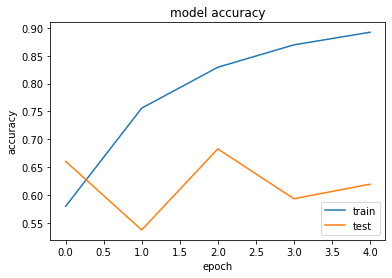

In [ ]:
target_names=['None','Support','Attack']
 
y_pred=[]
y_true=[]

# Assign one-hot encodings to Y values (0,1,2).
categorical_Y = to_categorical(Y_relation_type)

X_supporting_train, X_supporting_test, X_supporting_microtext_test  = X_supporting[sections_train_set], X_supporting[sections_test_set], X_supporting[sections_test_microtext_set]
X_supported_train, X_supported_test, X_supported_microtext_test  = X_supported[sections_train_set], X_supported[sections_test_set], X_supported[sections_test_microtext_set]
X_supporting_before_train, X_supporting_before_test, X_supporting_microtext_before_test = X_supporting_before[sections_train_set], X_supporting_before[sections_test_set], X_supporting_before[sections_test_microtext_set]
X_supported_before_train, X_supported_before_test, X_supported_microtext_before_test = X_supported_before[sections_train_set], X_supported_before[sections_test_set], X_supported_before[sections_test_microtext_set]
X_supporting_after_train, X_supporting_after_test, X_supporting_microtext_after_test = X_supporting_after[sections_train_set], X_supporting_after[sections_test_set], X_supporting_after[sections_test_microtext_set]
X_supported_after_train, X_supported_after_test, X_supported_microtext_after_test = X_supported_after[sections_train_set], X_supported_after[sections_test_set], X_supported_after[sections_test_microtext_set]
Y_train, Y_test, Y_microtext_test = categorical_Y[sections_train_set], categorical_Y[sections_test_set], categorical_Y[sections_test_microtext_set]

# Train the model.
model=train_MultiModal(X_supporting_train,X_supported_train,X_supporting_before_train,X_supported_before_train,X_supporting_after_train,X_supported_after_train,Y_train)

y_pred_temp=model.predict([X_supporting_microtext_test,X_supported_microtext_test,X_supporting_microtext_before_test,X_supported_microtext_before_test,X_supporting_microtext_after_test,X_supported_microtext_after_test])
for i in range(len(Y_microtext_test)):
  y_pred.append(np.argmax(y_pred_temp[i]))
  y_true.append(np.argmax(Y_microtext_test[i].tolist()))

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))   

              precision    recall  f1-score   support

        None       0.00      0.00      0.00         0
     Support       0.72      0.58      0.64       263
      Attack       0.33      0.05      0.08       108

    accuracy                           0.42       371
   macro avg       0.35      0.21      0.24       371
weighted avg       0.61      0.42      0.48       371



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


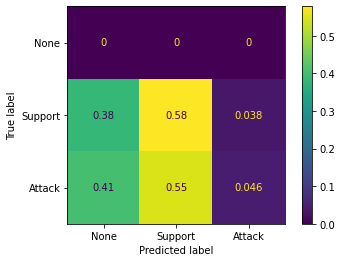

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()

## **Stab and Gurevych test set**

In [ ]:
y_pred=[]
y_true=[]

y_pred_temp=model.predict([X_supporting_test,X_supported_test,X_supporting_before_test,X_supported_before_test,X_supporting_after_test,X_supported_after_test])
for i in range(len(Y_test)):
  y_pred.append(np.argmax(y_pred_temp[i]))
  y_true.append(np.argmax(Y_test[i].tolist()))

# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        None       0.52      0.60      0.56       319
     Support       0.74      0.70      0.72       542
      Attack       0.00      0.00      0.00        28

    accuracy                           0.64       889
   macro avg       0.42      0.43      0.43       889
weighted avg       0.64      0.64      0.64       889



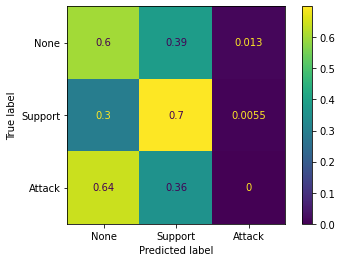

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()